# 데이터 로드 

In [1]:
import os 
from glob import glob 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import cv2 
import albumentations as A

In [2]:
def make_df(path):
  dirs = []
  for t in ['train','test']:
    for u in ['up','down']:
      dirs.extend(glob(os.path.join(path,t,u,'*.jpg')))
  df = pd.DataFrame(dirs)
  df['Train-Test'] = df[0].apply(lambda x : x.split('/')[-3])
  df['Up-Down'] = df[0].apply(lambda x : x.split('/')[-2])
  df.columns = ['Dirs','Train-Test','Up-Down']
  df = df.sort_values(by=['Dirs']).reset_index(drop=True)
  return df 

def train_test_split(df):
  train_df = df.loc[df['Train-Test']=='train'].drop(columns = ['Train-Test']).reset_index(drop=True)
  test_df = df.loc[df['Train-Test']=='test'].drop(columns = ['Train-Test']).reset_index(drop=True)
  return train_df, test_df

path = '/content/drive/MyDrive/Colab Notebooks/Repositary/IOT_education/classification/thumb'
df = make_df(path)
train_df, test_df = train_test_split(df)

In [3]:
label_encoder = {'up':1,
                 'down':0}
label_decoder = {b:a for a,b in label_encoder.items()}
opt = {}
opt['BATCH_SIZE'] = 16
opt['EPOCHS']  =30
opt['IMAGE_SIZE'] = 128
opt['label_encoder']= label_encoder
opt['label_decoder'] = label_decoder

#데이터 제너레이터 

In [4]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import Sequence
import math
from albumentations.augmentations.transforms import Rotate,VerticalFlip,HorizontalFlip
from albumentations.augmentations.transforms import RandomBrightnessContrast

class DataGenerator(Sequence):
  def __init__(self,
                 df=None,
                opt=None,
                shuffle : bool = False,
                augmentation : bool = False):
    self.df = df
    self.batch_size = opt['BATCH_SIZE']
    self.shuffle = shuffle
    self.augmentation = augmentation
    self.opt = opt 

        
  def __len__(self):
    return math.floor(len(self.df) / self.opt['BATCH_SIZE'])

  def on_epoch_end(self):
    self.indices = np.arange(len(self.df))
    if self.shuffle == True:
      np.random.shuffle(self.indices)
      self.timestamps = list(np.array(self.df)[self.indices])


  def image_augmentation(self,normal_image):
    transform = A.Compose([
      RandomBrightnessContrast(brightness_limit=0.5,contrast_limit=0.5,p=1),
      Rotate(),
      VerticalFlip(),
      HorizontalFlip()])
    augmentated_image = transform(image= normal_image)['image']
    return augmentated_image

  def img_preprocess(self,img,augmentation):
    if augmentation:
      img = self.image_augmentation(img)
    img = cv2.resize(img,dsize=(self.opt['IMAGE_SIZE'],self.opt['IMAGE_SIZE']))  
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = img/255.
    return img 
    
  def __getitem__(self, index):
    self.batch_df = self.df[index*self.batch_size:(index+1)*self.batch_size]

    #image 
    batch_imgs = []
    for i in range(self.batch_size):
      img = cv2.imread(self.batch_df.iloc[i]['Dirs'])
      img = self.img_preprocess(img,self.augmentation)
      batch_imgs.append(img)
    batch_imgs = np.array(batch_imgs).astype(np.float32)
    

    #label 
    batch_labels = np.array(self.batch_df['Up-Down'].map(opt['label_encoder']))
    
    return batch_imgs, batch_labels 

#모델

In [5]:
from tensorflow.keras import optimizers
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Activation,Dense,Flatten
from tensorflow.keras.layers import BatchNormalization, Input, Dropout,Reshape
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV3Small,MobileNetV2,MobileNet
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow import keras

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 128)         1474688   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 128)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 64)          73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 64)         0         
 2D)                                                       

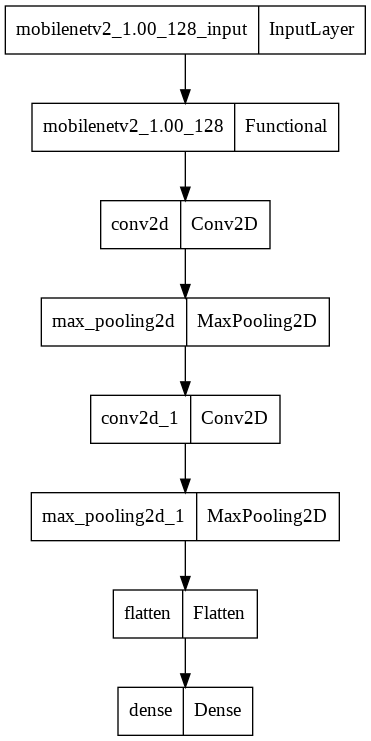

In [6]:

input_shape = (opt['IMAGE_SIZE'],opt['IMAGE_SIZE'],3)

Pretrained = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape) #size -> 256, 256 
Pretrained.trainable = False


model = keras.Sequential()
model.add(Pretrained)
# model.add(Input(shape = input_shape))
model.add(Conv2D(128,3,padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(64,3,padding='same'))
model.add(MaxPooling2D())
# model.add(Conv2D(32,3,padding='same'))
# model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(2,activation='softmax'))
model.summary()
plot_model(model)

In [7]:
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output
class PlotLosses(Callback):

  def on_train_begin(self, logs={}):
    self.epochs = []
    self.losses = []
    self.val_losses = []
    self.logs = []
    self.fig = plt.figure()


  def on_epoch_end(self, epoch, logs={}):
    self.epochs.append(epoch)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    clear_output(wait=True)
    plt.plot(self.epochs, self.losses, label="loss")
    plt.plot(self.epochs, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])

#call backs 선언
plot_losses = PlotLosses()

#학습

In [8]:
valid_df = train_df.iloc[150:]
train_df = train_df.iloc[:150]

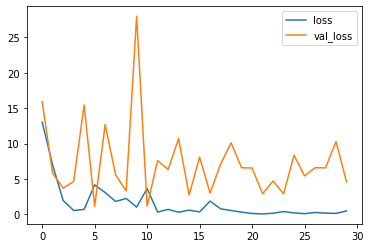

loss =  0.5017268657684326 , val_loss =  4.5849385261535645
9/9 [==============================] - 3s 313ms/step - loss: 0.5017 - acc: 0.9306 - val_loss: 4.5849 - val_acc: 0.6875


In [9]:
train_generator = DataGenerator(df = train_df,
                                opt = opt,
                                shuffle=True,
                                augmentation=True)
valid_generator = DataGenerator(df = valid_df,
                                opt = opt,
                                shuffle=False,
                                augmentation=False)

test_generator = DataGenerator(df = test_df,
                                opt = opt,
                                shuffle=False,
                                augmentation=False)
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])
history= model.fit(train_generator,
                   validation_data=valid_generator,
                   epochs = opt['EPOCHS'],
                   verbose=1,
                   callbacks = plot_losses)


#모델 변환
- tensorflowjs 를 이용해 keras 모델 weight 파일을 json 파일로 변환 
- 그 후 구글 드라이브에 저장 

In [ ]:
!pip install tensorflowjs

In [16]:
!mkdir '/content/drive/MyDrive/model'

In [15]:
import tensorflowjs as tfjs

save_path = '/content/drive/MyDrive'
tfjs.converters.save_keras_model(model,save_path)